# Imputation for real dataset by creating synthetic dataset as a representation of real dataset
## Author: Rahul Bhadani
In this notebook, we will use splatter to create synthetic dataset from a real dataset. Then we will develop a machine learning model for imputation and use that model to impute on real dataset.

In [7]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
# %%R will execute R command
# -o flag gives a way to transfer R variables to Jupyter Notebook

In [9]:
import scanpy
import pandas
import csv
import numpy as np

In [10]:
# This python script lets read 10X Genomics using scanpy
path = "/home/ivory/VersionControl/scRNASeq/data/pbmc3k_filtered_gene_bc_matrices/hg19"
# Scanpy doesn't require pass cellfile, genefile and UMIfile separately as long as names of the files are barcodes.tsv, genes.tsv and matrix.mtx - pasing path of the folder where lie is sufficient
anndata = scanpy.read_10x_mtx(path, var_names='gene_symbols')
## get the UMI count data
count = anndata.X ## This is sparse matrix
# Since Count data is sparse matrix, we need to convert to dataframe
# however, it should be noted that the dense matrix as a result of conversion
# is the transpose of the one you get by doing similar conversion in R.
count =pandas.DataFrame(count.toarray())
## get the gene info
genes = anndata.var_names

## Get the cell info
cells = anndata.obs_names

count.columns =anndata.var_names
count.index = anndata.obs_names

# Now transpose so that gene names are same as row names and cell types are same  column names
count = count.T

count = count.astype(int)
count

# We need to convert Pandas dataframe to numpy
numpycount = pandas.DataFrame(count).to_numpy()

In [11]:
%%R -i numpycount -o nGenes -o nCells -o seed -o nBatches -o batchCells -o facLoc -o facScale -o meanshape -o meanrate -o libloc -o libscale -o libnorm -o outprob -o outfacLoc -o outfacScale -o nGroups -o groupprob -o deprob -o dedownProb -o defacLoc -o defacScale -o bcvcommon  -o bcvdf -o dropouttype -o dropoutmid -o dropoutshape -o pathfrom -o pathnSteps -o pathskew -o pathnonlinearProb -o pathsigmaFac -o counts -o truecounts -o dropout -o geneinfo -o cellinfo 
library(splatter)
params <- splatEstimate(numpycount)
# params is S4 class, hence, its attributes can be accessed using @
# see http://oshlacklab.com/splatter/reference/SplatParams.html for 
# list of all attibutes

nGenes <- params@nGenes # The number of genes to simulate.
nCells <- params@nCells # The number of cells to simulate.
seed <- params@seed #

nBatches <- params@nBatches #The number of batches to simulate.
batchCells <- params@batchCells #Vector giving the number of cells in each batch.
facLoc <- params@batch.facLoc #Location (meanlog) parameter for the batch effect factor log-normal distribution. Can be a vector.
facScale <- params@batch.facScale #Scale (sdlog) parameter for the batch effect factor log-normal distribution. Can be a vector.

meanshape <- params@mean.shape # Shape parameter for the mean gamma distribution.
meanrate <- params@mean.rate #Rate parameter for the mean gamma distribution.

libloc <- params@lib.loc #Location (meanlog) parameter for the library size log-normal distribution, or mean parameter if a normal distribution is used.
libscale <- params@lib.scale #Scale (sdlog) parameter for the library size log-normal distribution, or sd parameter if a normal distribution is used.
libnorm <- params@lib.norm #Logical. Whether to use a normal distribution for library sizes instead of a log-normal.

outprob <- params@out.prob #Probability that a gene is an expression outlier.
outfacLoc <- params@out.facLoc #Location (meanlog) parameter for the expression outlier factor log-normal distribution.
outfacScale <- params@out.facScale # Scale (sdlog) parameter for the expression outlier factor log-normal distribution.

nGroups <- params@nGroups # The number of groups or paths to simulate.
groupprob <- params@group.prob # Probability that a cell comes from a group.

deprob <- params@de.prob # Probability that a gene is differentially expressed in a group. Can be a vector.
dedownProb <- params@de.downProb # Probability that a differentially expressed gene is down-regulated. Can be a vector.
defacLoc <- params@de.facLoc # Location (meanlog) parameter for the differential expression factor log-normal distribution. Can be a vector.
defacScale <- params@de.facScale # Scale (sdlog) parameter for the differential expression factor log-normal distribution. Can be a vector.

bcvcommon <- params@bcv.common # Underlying common dispersion across all genes.
bcvdf <- params@bcv.df # Degrees of Freedom for the BCV inverse chi-squared distribution.

# The type of dropout to simulate. 
# "none" indicates no dropout, "experiment" is global dropout using the 
# same parameters for every cell, "batch" uses the same parameters 
# for every cell in each batch, "group" uses the same parameters for 
# every cell in each groups and "cell" uses a different 
# set of parameters for each cell.
dropouttype <- params@dropout.type 
dropoutmid <- params@dropout.mid # Midpoint parameter for the dropout logistic function.
dropoutshape <- params@dropout.shape # Shape parameter for the dropout logistic function.

# Vector giving the originating point of each path. 
# This allows path structure such as a cell type which 
# differentiates into an intermediate cell type that 
# then differentiates into two mature cell types.
# A path structure of this form would have a "from" 
# parameter of c(0, 1, 1) (where 0 is the origin). 
# If no vector is given all paths will start at the origin.
pathfrom <- params@path.from
# Vector giving the number of steps to simulate
# along each path. If a single value is given it
# will be applied to all paths. This parameter was
# previously called path.length.
pathnSteps <- params@path.nSteps
# Vector giving the skew of each path. Values closer 
# to 1 will give more cells towards the starting
# population, values closer to 0 will give more cells
# towards the final population. If a single value is
# given it will be applied to all paths.
pathskew <- params@path.skew

# Probability that a gene follows a non-linear path 
# along the differentiation path. This allows more 
# complex gene patterns such as a gene being equally 
# expressed at the beginning an end of a path but lowly 
# expressed in the middle.
pathnonlinearProb <- params@path.nonlinearProb
# Sigma factor for non-linear gene paths. 
# A higher value will result in more extreme non-linear
# variations along a path.
pathsigmaFac <- params@path.sigmaFac

# Explicitly set dropout to experiment.
params@dropout.type <- 'experiment'

print(params)

sim <- splatSimulate(params)
counts <- as.data.frame(t(counts(sim)))
truecounts <- as.data.frame(t(assays(sim)$TrueCounts))
dropout <- assays(sim)$Dropout
mode(dropout) <- 'integer'
cellinfo   <- as.data.frame(colData(sim))
geneinfo   <- as.data.frame(rowData(sim))



A Params object of class SplatParams 
Parameters can be (estimable) or [not estimable], 'Default' or  'NOT DEFAULT' 
Secondary parameters are usually set during simulation

Global: 
(GENES)  (CELLS)   [Seed] 
  32738     2700   437005 

28 additional parameters 

Batches: 
    [BATCHES]  [BATCH CELLS]     [Location]        [Scale] 
            1           2700            0.1            0.1 

Mean: 
           (RATE)            (SHAPE) 
 12.8304876873963  0.513586791339809 

Library size: 
       (LOCATION)            (SCALE)             (Norm) 
 7.67803667140404  0.431431376197616              FALSE 

Exprs outliers: 
     (PROBABILITY)          (LOCATION)             (SCALE) 
0.0190450278873623    5.17840706339895   0.984099937884926 

Groups: 
     [Groups]  [Group Probs] 
            1              1 

Diff expr: 
[Probability]    [Down Prob]     [Location]        [Scale] 
          0.1            0.5            0.1            0.4 

BCV: 
    (COMMON DISP)              (DOF) 
0.2844

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Done!



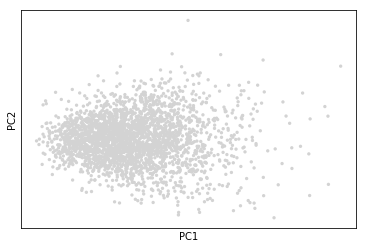

In [12]:
counts.columns = genes
counts.index = cells
simdata = scanpy.AnnData(counts.values, obs=cells, var=genes)
simdata.obs_names = cells
simdata.var_names = genes
#scanpy.pp.filter_genes(adata, min_counts=1)
scanpy.pp.normalize_per_cell(simdata)
scanpy.pp.log1p(simdata)
scanpy.pp.pca(simdata)
scanpy.pl.pca_scatter(simdata)

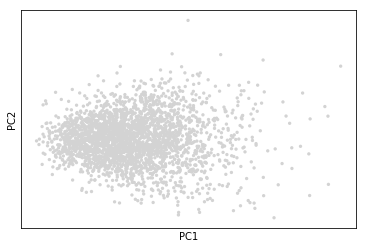

In [13]:
truecounts.columns = genes
truecounts.index = cells
truedata = scanpy.AnnData(truecounts.values, obs=cells, var=genes)
truedata.obs_names = cells
truedata.var_names = genes
#scanpy.pp.filter_genes(adata, min_counts=1)
scanpy.pp.normalize_per_cell(truedata)
scanpy.pp.log1p(truedata)
scanpy.pp.pca(truedata)
scanpy.pl.pca_scatter(truedata)

In [14]:
len(anndata.var_names)

32738

In [15]:
len(anndata.obs_names)

2700

In [16]:
len(genes)

32738

In [17]:
len(cells)

2700

In [18]:
anndata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name=0, length=2700)

In [19]:
anndata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [20]:
counts.index 

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name=0, length=2700)

In [21]:
simdata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name=0, length=2700)

In [22]:
simdata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [23]:
anndata.var_names_make_unique()

In [24]:
anndata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [25]:
anndata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name=0, length=2700)

In [26]:
simdata.var_names_make_unique()
truedata.var_names_make_unique()

In [27]:
simdata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [28]:
simdata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name=0, length=2700)

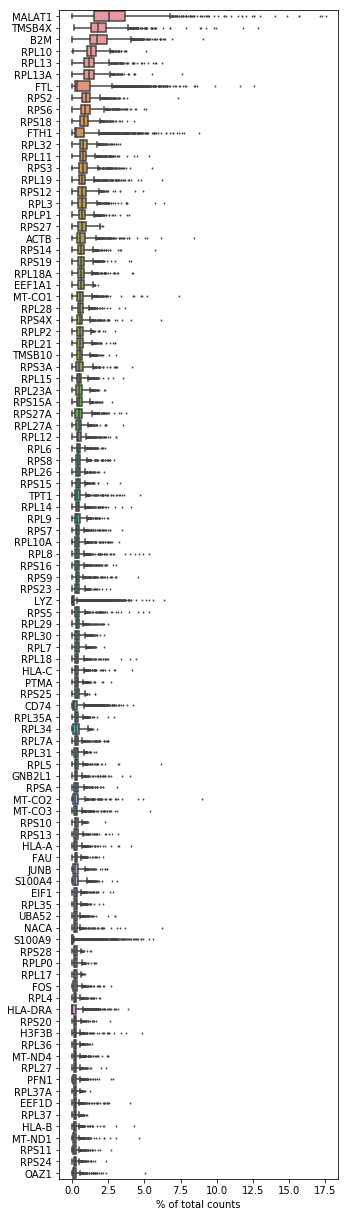

In [29]:
scanpy.pl.highest_expr_genes(anndata, n_top=100, )

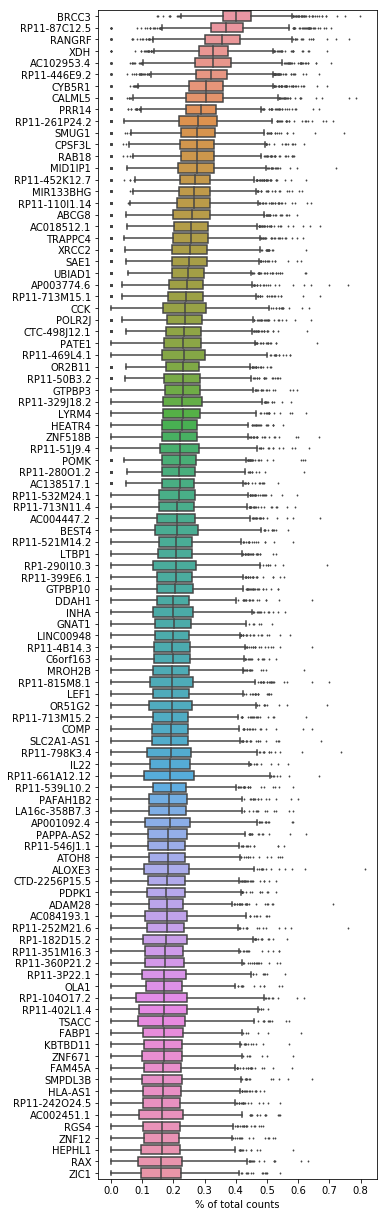

In [30]:
scanpy.pl.highest_expr_genes(simdata, n_top=100, )

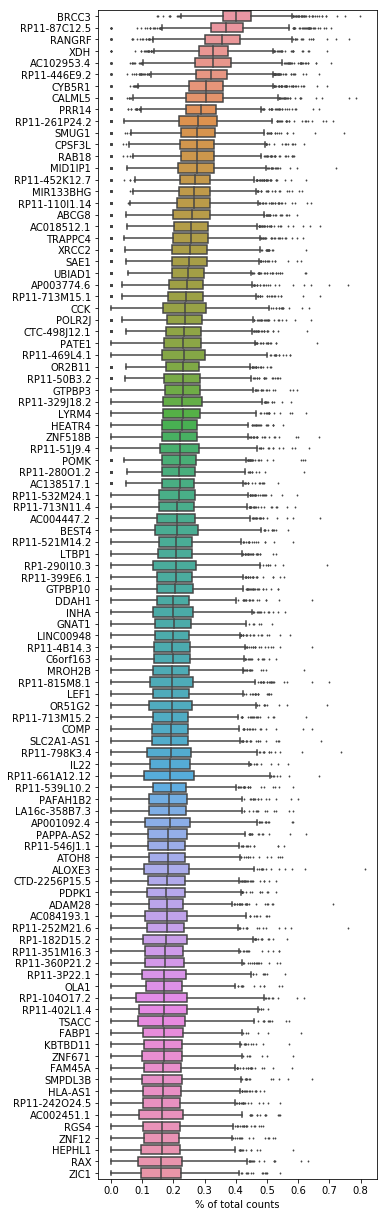

In [31]:
scanpy.pl.highest_expr_genes(truedata, n_top=100, )

In [32]:
 np.array_equal(counts.values, truecounts.values)

True

In [33]:
counts

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2-1,AL590523.1,CT476828.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
0,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTGAGCTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTGATCAGC-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACCGTGCTTCCG-1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCACTGGTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTGACCAGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTGGTTCTT-1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AAACGCTGTAGCCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
truecounts

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2-1,AL590523.1,CT476828.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
0,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTGAGCTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTGATCAGC-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACCGTGCTTCCG-1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCACTGGTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTGACCAGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTGGTTCTT-1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AAACGCTGTAGCCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
